In [160]:
# pip install matplotlib

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from scipy.stats import linregress, pearsonr

# Read in data 

In [162]:
dir = "/Users/rickiheicklen/Development/Github/scholars-and-sommeliers/"
df_orig = pd.read_csv(dir + "data.csv")
df_sources = df_orig[[x for x in df_orig.columns if 'Source' in x or 'Person' in x]]
df_wines = df_orig[[x for x in df_orig.columns if 'Wine' in x or 'Person' in x]]

In [163]:
# Sources:
# Abarbanel, Bartenura, Alfasi, Sforno, Rashi, Schwartz

df_sources = df_sources.rename(columns={'Source 1': 'Abarbanel', 
                   'Source 2': 'Bartenura',
                   'Source 3': 'Alfasi',
                   'Source 4': 'Sforno',
                   'Source 5': 'Rashi',
                   'Source 6': 'Schwartz'})

# Wines: 
# Alfasi, Abarbanel, Bartenura, Rashi, Sforno, Schwartz

df_wines = df_wines.rename(columns={'Wine A': 'Alfasi', 
                   'Wine B': 'Abarbanel',
                   'Wine C': 'Bartenura',
                   'Wine D': 'Rashi',
                   'Wine E': 'Sforno',
                   'Wine F': 'Schwartz'
                   })
                

In [164]:
df_sources_long = df_sources.melt(id_vars=["Person"], var_name="Rishon", value_name="Source")
df_wines_long = df_wines.melt(id_vars=["Person"], var_name="Rishon", value_name="Wine")

In [165]:
df = pd.merge(df_sources_long, df_wines_long, on=['Person', 'Rishon'])

In [166]:
df[df["Person"] == "Shalhevet Schwartz"]

,Person,Rishon,Source,Wine
10,Shalhevet Schwartz,Abarbanel,6,1.0
21,Shalhevet Schwartz,Bartenura,3,2.0
32,Shalhevet Schwartz,Alfasi,7,5.0
43,Shalhevet Schwartz,Sforno,2,6.0
54,Shalhevet Schwartz,Rashi,3,1.0
65,Shalhevet Schwartz,Schwartz,5,3.0


In [167]:
# Select the columns to impute
numeric_cols = ['Source', 'Wine']
# Select the numerical columns
# numeric_cols = df.select_dtypes(include='number').columns

name_cols = ['Person','Rishon']
# Group the data by the 'group' column
groups = df.groupby('Person')

In [177]:
# Set which variable to color the points by (either Person or Rishon)
factor = "Rishon"

In [186]:
df_imputed = df[df['Person'] != "Chana Fisch"]

In [188]:
df_imputed

,Person,Rishon,Source,Wine
0,Ricki Heicklen,Abarbanel,4,6.0
1,Joe Blumberg,Abarbanel,4,6.0
2,Daniel Peled-Schwartz,Abarbanel,5,5.0
3,Avital Morris,Abarbanel,8,4.0
5,Jen Greenberg,Abarbanel,1,4.0
6,Jasmine Peled-Schwartz,Abarbanel,2,6.0
7,Ronit Morris,Abarbanel,6,3.0
8,Susan Palefsky,Abarbanel,2,2.0
9,Tadhg Cleary,Abarbanel,7,5.0
10,Shalhevet Schwartz,Abarbanel,6,1.0


In [190]:
# Make color map and labels
colors, color_labels = pd.factorize(df_imputed[factor])
color_labels = color_labels.tolist()
color_map = cm.get_cmap('tab20')

# Fit a linear regression model
x = df_imputed['Source']
y = df_imputed['Wine']
coefficients = np.polyfit(x, y, 1)
# polynomial = np.poly1d(coefficients)

# # Fit a linear regression model
# slope, intercept, r_value, p_value, std_err = linregress(x, y)

# # Calculate the correlation coefficient
# r_corr = pearsonr(x, y)[0]

# # Calculate the R squared value
# r_squared = r_value ** 2

# # Create the scatterplot
# scatter = plt.scatter(x, y, c=colors, cmap=color_map, label="Data")

# # Plot the regression
# plt.plot(x, intercept + slope * x, 'r--')

# # Add the correlation coefficient and R squared value to the plot
# plt.text(1.05, 0.15, f'Correlation coefficient: {r_corr:.3f}', transform=plt.gca().transAxes)
# plt.text(1.05, 0.1, f'R$^2$: {r_squared:.3f}', transform=plt.gca().transAxes)
# plt.text(1.05, 0.05, f'p-value: {p_value:.3f}', transform=plt.gca().transAxes)


# # Add the legend
# handles, _ = scatter.legend_elements()
# legend = plt.legend(handles=handles, labels=color_labels, bbox_to_anchor=(1.05, 1), title=factor)
# legend.get_title().set_weight('bold')

# # Add axes labels
# plt.xlabel('Source quality')
# plt.ylabel('Wine quality')

# # Add a title
# plt.title('Scholars and Sommeliers: Rishon Quality Plot')

TypeError: 'NoneType' object is not callable

In [193]:
import numpy as np
np.polyfit(x,y,deg=1)

TypeError: 'NoneType' object is not callable

In [ ]:
p_value

0.06517501760996625

# Everything below this is scrap for now

In [195]:
import numpy as np

# Generate some sample data
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([0.1, 0.9, 2.2, 2.8, 4.1, 4.9])

# Fit a second-degree polynomial to the data
coefficients = np.polyfit(x, y, 2)

# # Use the coefficients to create a polynomial function
# polynomial_func = np.poly1d(coefficients)

# # Evaluate the function at some new points
# new_points = np.array([6, 7, 8])
# new_values = polynomial_func(new_points)

# print(new_values)

TypeError: 'NoneType' object is not callable

In [198]:
import numpy as np

# Generate some sample data with explicit data types
x = np.array([0, 1, 2, 3, 4, 5], dtype=np.float64)
y = np.array([0.1, 0.9, 2.2, 2.8, 4.1, 4.9], dtype=np.float64)

# Fit a second-degree polynomial to the data
coefficients = np.polyfit(x, y, 2)

# Use the coefficients to create a polynomial function
polynomial_func = np.poly1d(coefficients)

# Evaluate the function at some new points
new_points = np.array([6, 7, 8], dtype=np.float64)
new_values = polynomial_func(new_points)

print(new_values)

TypeError: 'NoneType' object is not callable

In [174]:
### Scrap from trying to use SimpleImputer ###
# 
# # Create a SimpleImputer to impute missing values with the mean
# imputer = SimpleImputer(strategy='mean')
# # [group.columns[~group.columns.isin(numeric_cols)] for _, group in groups]
# for a, group in groups:
#     print(group) 
# [group[group.columns[~group.columns.isin(numeric_cols)]] for _, group in groups]
# for a, group in groups:
#     print(group) 
#     for col in numeric_cols:
#         print(col)
#         print(imputer)
#         print(group[col])
#         # imputer.fit_transform(group[col].reshape(-1,1))
# [group[group.columns[~group.columns.isin(numeric_cols)]] for _, group in groups]
# mean_values = [group[col]]
# imputer.fit_transform([1,2,3,np.nan,3].toarray())
# df_imputed = pd.concat([group[group.columns[~group.columns.isin(numeric_cols)]].assign(**{col: imputer.fit_transform(group[[col]]) for col in numeric_cols}) for _, group in groups])


In [ ]:
# Some code we are no longer using:
# 
# # # Create the scatter plot
# scatter = plt.scatter(df['score_source'], df['score_wine'], c=df['rishon_encoded'], cmap="viridis")

# # Add the color bar
# colorbar = plt.colorbar(scatter, label="Person")

# # Set the tick marks and labels on the color bar
# colorbar.set_ticks(range(len(person_labels)))
# colorbar.set_ticklabels(person_labels)


# plt.legend(handles=df["person_encoded"], labels=person_labels)

# # Add the color bar
# colorbar = plt.colorbar(scatter, cmap=color_map, label="Person",  extendfrac="auto", spacing="uniform", boundaries)
 
# # Set the tick marks and labels on the color bar
# colorbar.set_ticks(range(len(person_labels)))
# colorbar.set_ticklabels(person_labels)

In [ ]:
df = pd.read_csv("/Users/rickiheicklen/Github/scholars-and-sommeliers/data.csv")
df_sources = df_orig[[x for x in df_orig.columns if 'Source' in x or 'Person' in x]]
df_wines = df_orig[[x for x in df_orig.columns if 'Wine' in x or 'Person' in x]]
df_sources['Type'] = "Source"
df_wines['Type'] = "Wine"

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rickiheicklen/Github/scholars-and-sommeliers/data.csv'

In [ ]:
# Wines:
# Abarbanel, Bartenura, Alfasi, Sforno, Rashi, Schwartz

# Wines: 
# Alfasi, Abarbanel, Bartenura, Rashi, Sforno, Schwartz

df_orig.rename(columns={'Source 1': 'Abarbanel (Source)', 
                   'Source 2': 'Bartenura (Source)',
                   'Source 3': 'Alfasi (Source)',
                   'Source 4': 'Sforno (Source)',
                   'Source 5': 'Rashi (Source)',
                   'Source 6': 'Schwartz (Source)',
                   'Wine A': 'Alfasi (Wine)', 
                   'Wine B': 'Abarbanel (Wine)',
                   'Wine C': 'Bartenura (Wine)',
                   'Wine D': 'Rashi (Wine)',
                   'Wine E': 'Sforno (Wine)',
                   'Wine F': 'Schwartz (Wine)'
                   },
                   inplace=True)

In [ ]:
df_orig
df.melt(id_vars=["Person", "Type"], var_name="Rishon", value_name="score").head(60)

KeyError: "The following 'id_vars' are not present in the DataFrame: ['Type']"

In [ ]:
df_sources_long = df_sources.melt(id_vars=["Person", "Type"], var_name="Rishon", value_name="score")
df_wines_long = df_wines.melt(id_vars=["Person", "Type"], var_name="Rishon", value_name="score")

In [ ]:
pd.merge(df_sources_long, df_wines_long, on=['Person', 'Rishon'], suffixes=('_source', '_wine'))

,Person,Rishon,Source,Wine
0,Ricki Heicklen,Abarbanel,4.0,6.0
1,Joe Blumberg,Abarbanel,4.0,6.0
2,Daniel Peled-Schwartz,Abarbanel,5.0,5.0
3,Avital Morris,Abarbanel,8.0,4.0
4,Chana Fisch,Abarbanel,5.0,2.0
...,...,...,...,...
61,Jasmine Peled-Schwartz,Schwartz,10.0,1.0
62,Ronit Morris,Schwartz,10.0,1.0
63,Susan Palefsky,Schwartz,5.0,1.0
64,Tadhg Cleary,Schwartz,10.0,1.0


In [ ]:
df.melt(id_vars=["Person", "Type"], var_name="Rishon", value_name="score").head(60)

KeyError: "The following 'id_vars' are not present in the DataFrame: ['Type']"

In [ ]:
df = pd.read_csv("/Users/rickiheicklen/Github/scholars-and-sommeliers/data.csv")
df_sources = df[[x for x in df.columns if 'Source' in x or 'Person' in x]]
df_wines = df[[x for x in df.columns if 'Wine' in x or 'Person' in x]]
df_sources['Type'] = "Source"
df_wines['Type'] = "Wine"

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rickiheicklen/Github/scholars-and-sommeliers/data.csv'

In [ ]:
# Sources:
# Abarbanel, Bartenura, Alfasi, Sforno, Rashi, Schwartz

df_sources = df_sources.rename(columns={'Source 1': 'Abarbanel', 
                   'Source 2': 'Bartenura',
                   'Source 3': 'Alfasi',
                   'Source 4': 'Sforno',
                   'Source 5': 'Rashi',
                   'Source 6': 'Schwartz'})

In [ ]:
# Wines: 
# Alfasi, Abarbanel, Bartenura, Rashi, Sforno, Schwartz

df_wines = df_wines.rename(columns={'Wine A': 'Alfasi', 
                   'Wine B': 'Abarbanel',
                   'Wine C': 'Bartenura',
                   'Wine D': 'Rashi',
                   'Wine E': 'Sforno',
                   'Wine F': 'Schwartz'
                   })
                

In [ ]:
df = pd.concat([df_sources, df_wines])

In [ ]:
# def sources_and_wines(group):
#     sources = group[sources].values.tolist()
#     wines = group[wines].values.tolist()
#     return pd.Series({"Sources": sources, "Wines": wines})

# df_new = df.groupby("Person").apply(sources_and_wines).reset_index()

In [ ]:
# # Wines:
# # Abarbanel, Bartenura, Alfasi, Sforno, Rashi, Schwartz

# # Wines: 
# # Alfasi, Abarbanel, Bartenura, Rashi, Sforno, Schwartz

# df.rename(columns={'Source 1': 'Abarbanel (Source)', 
#                    'Source 2': 'Bartenura (Source)',
#                    'Source 3': 'Alfasi (Source)',
#                    'Source 4': 'Sforno (Source)',
#                    'Source 5': 'Rashi (Source)',
#                    'Source 6': 'Schwartz (Source)',
#                    'Wine A': 'Alfasi (Wine)', 
#                    'Wine B': 'Abarbanel (Wine)',
#                    'Wine C': 'Bartenura (Wine)',
#                    'Wine D': 'Rashi (Wine)',
#                    'Wine E': 'Sforno (Wine)',
#                    'Wine F': 'Schwartz (Wine)'
#                    },
#                    inplace=True)

In [ ]:
df

,Person,Abarbanel,Bartenura,Alfasi,Sforno,Rashi,Schwartz
0,Ricki Heicklen,4,8.0,9,6.0,1.0,11.0
1,Joe Blumberg,4,4.0,7,7.0,8.0,11.0
2,Daniel Peled-Schwartz,5,-1.0,10,3.0,7.0,5.0
3,Avital Morris,8,4.0,4,3.0,10.0,9.0
4,Chana Fisch,5,3.0,10,4.0,5.0,10.0
5,Jen Greenberg,1,1.0,1,1.0,5.0,10.0
6,Jasmine Peled-Schwartz,2,5.0,5,5.0,4.0,10.0
7,Ronit Morris,6,1.0,7,2.0,5.0,10.0
8,Susan Palefsky,2,3.0,4,3.0,4.0,5.0
9,Tadhg Cleary,7,2.0,4,10.0,5.0,10.0


### scrap from ChatGPT

In [ ]:
import pandas as pd

data = {
    'Student': ['Alice', 'Bob', 'Charlie'],
        'Color': ['red', 'yellow', 'blue'],
    'Study Hours': [[0, 1, 2, 3], [4, 5, 6], [7, 8, 9, 10]],
    'Test Scores': [[10, 20, 30, 40], [50, 60, 70], [80, 90, 100, 110]]
}

df = pd.DataFrame(data)
df

,Student,Color,Study Hours,Test Scores
0,Alice,red,"[0, 1, 2, 3]","[10, 20, 30, 40]"
1,Bob,yellow,"[4, 5, 6]","[50, 60, 70]"
2,Charlie,blue,"[7, 8, 9, 10]","[80, 90, 100, 110]"


In [ ]:

# Flatten the 'Study Hours' and 'Test Scores' columns
df['Study Hours'] = df['Study Hours'].apply(lambda x: x[0])
df['Test Scores'] = df['Test Scores'].apply(lambda x: x[0])

# Create the scatter plot
# plt.scatter(df['Study Hours'], df['Test Scores'], c=df['Student'])

TypeError: 'int' object is not subscriptable

ValueError: setting an array element with a sequence.

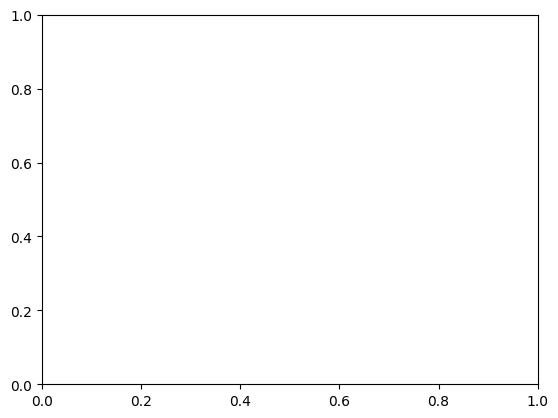

In [ ]:
colors = ['red', 'blue', 'green']

# Create the scatter plot
plt.scatter(df['Study Hours'], df['Test Scores'], c=colors)


In [ ]:
## Attempt at graphing rishonim

## Attempt at graphing rishonim

In [ ]:
df

,Student,Color,Study Hours,Test Scores
0,Alice,red,0,10
1,Bob,yellow,4,50
2,Charlie,blue,7,80


In [ ]:
data = {
    'Alice': [[0, 1, 2, 3], [10, 20, 30, 40]],
    'Bob': [[4, 5, 6], [50, 60, 70]],
    'Charlie': [[7, 8, 9, 10], [80, 90, 100, 110]]
}

In [ ]:
data

{'Alice': [[0, 1, 2, 3], [10, 20, 30, 40]],
 'Bob': [[4, 5, 6], [50, 60, 70]],
 'Charlie': [[7, 8, 9, 10], [80, 90, 100, 110]]}

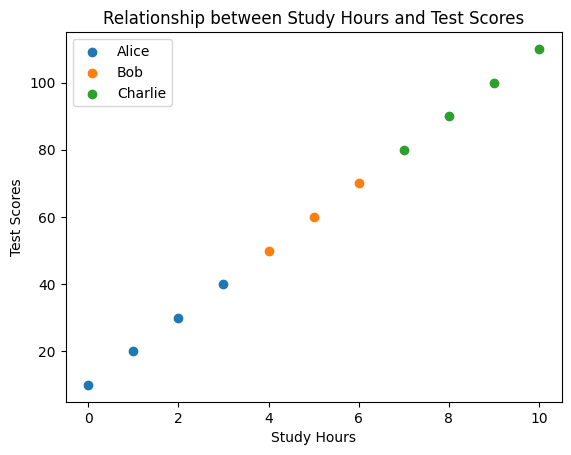

In [ ]:
# Loop through the data and plot each student's data
for student, (study_hours, test_scores) in data.items():
    plt.scatter(study_hours, test_scores, label=student)

# Add labels and title
plt.xlabel('Study Hours')
plt.ylabel('Test Scores')
plt.title('Relationship between Study Hours and Test Scores')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Loop through the data and plot each student's data
for student, (study_hours, test_scores) in data.items():
    plt.scatter(study_hours, test_scores, label=student)

# Add labels and title
plt.xlabel('Study Hours')
plt.ylabel('Test Scores')
plt.title('Relationship between Study Hours and Test Scores')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
for index, row in df.iterrows():
    plt.scatter(Source)
    print(row['Person'], row['Abarbanel (Source)'])


Ricki Heicklen 4
Joe Blumberg 4
Daniel Peled-Schwartz 5
Avital Morris 8
Chana Fisch 5
Jen Greenberg 1
Jasmine Peled-Schwartz 2
Ronit Morris 6
Susan Palefsky 2
Tadhg Cleary 7
Shalhevet Schwartz 6


In [ ]:
df = df.assign(Sources=lambda x: (x['Abarbanel (Source)'], x['Bartenura (Source)']))

KeyError: 'Abarbanel (Source)'

In [ ]:
def sources_and_wines(group):
    sources = group[sources].values.tolist()
    wines = group[wines].values.tolist()
    return pd.Series({"sources": sources, "wines": wines})

df_new = df.groupby("Person").apply(scores_and_dates).reset_index()

NameError: name 'scores_and_dates' is not defined

In [ ]:
df.drop(tyoe)

NameError: name 'tyoe' is not defined